# Use Hawkes processes in Cramér-Lundberg type model 

## Libraries import 


In [28]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()

from ipywidgets import interact, widgets

from numba import njit, prange

We parallelize computations thanks to the $Numba$ library.

## Simulations 

### Homogeneous Poisson Processes`

We simulate an HPP with rate $\lambda$ on $[0,T]$.`


In [12]:
def Simulate_HPP(lamb, T):
    n = 0
    t = [- np.log(npr.random()) / lamb]
    while t[-1] <= T:
        u = npr.random()
        w = - np.log(u) / lamb
        t.append(t[-1] + w)
    return t[:-1]

### Inhomogeneous Poisson Processes

In the case of HPP, we need a fixed rate intensity but now we want to simulate an IPP. So we vary the intensity $\lambda$ according to a deterministic function of time.

So we determine lambda_bar such as $sup_{0\leq t \leq T} \lambda(t)$. 

Inspired on Lewis and Shelder, 1979, p.7, Algorithm 1, we simulate a IPP with bounder intensity function $\lambda(t)$ on $[0,T]$. 

In [13]:
def Simulate_IPP(lamb, T):
    n = 0
    m = 0
    t = []
    s = 0
    lamb_bar = max([lamb(t) for t in np.arange(0, T, 0.1)])
    while s < T:
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        if D < lamb(s)/lamb_bar:
            t.append(s)
    if t[-1] < T:
        return t
    else:
        return t[:-1]

### Intensity function for Hawkes Process 

In order to simulate a Hawkes Process, we need to simulate $\lambda(t)$ as a left-contunous stochastic process given by the Stieljes integral : 
 
 $\lambda(t)$ = $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) $.


In [14]:
@njit
def lambda_bar(mu, alpha, beta, s, tau):
    S = mu
    for t in tau:
        S += alpha * np.exp(- beta * (s - t))
    return S

### Hawkes Processes

The simulation of a univariate Hawkes Process is based on the exponential kernel $\gamma(u) = \alpha \exp({-\beta (u)})$ on $[0,T]$. 

In [15]:
@njit
def Simulate_Hawkes(mu, alpha, beta, T):    
    tau = [0.0]  # Necessary to Numba
    s = 0
    while s < T:
        u = npr.random()
        lamb_bar = lambda_bar(mu, alpha, beta, s, tau[1:])  # We don't take the first 0.0
        w = -np.log(u) / lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar(mu, alpha, beta, s, tau[1:]):  # We don't take the first 0.0
            tau.append(s)
        
    # We take off the first 0 in both cases
    if tau[-1] < T:
        return tau[1:]
    else:
        return tau[1:-1]
    
def lamb_Hawkes(t, tau, mu, alpha, beta):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) for Tau in tau_inf])

## Display functions 

The first one allows to plot a Poisson Process. 

In [16]:
def plot_PP(t):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.step([0] + t, [0] + list(range(len(t))))
    plt.scatter(t,[0] * len(t), color='r')
    for h, T in enumerate(t):
        plt.plot([T, T], [0, h], '--', color="darkred")
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("N(t)", fontsize=20)
    plt.show()

The second one allows to plot the simulation of a Hawkes Process. 

In [17]:
def plot_Hawkes(mu, alpha, beta, T):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau = Simulate_Hawkes(mu, alpha, beta, T)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes(t, tau, mu, alpha, beta) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes(Tau, tau, mu, alpha, beta)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Hawkes Process, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

## Results 

We simulate an HPP with rate $3$ on $[0,15]$.

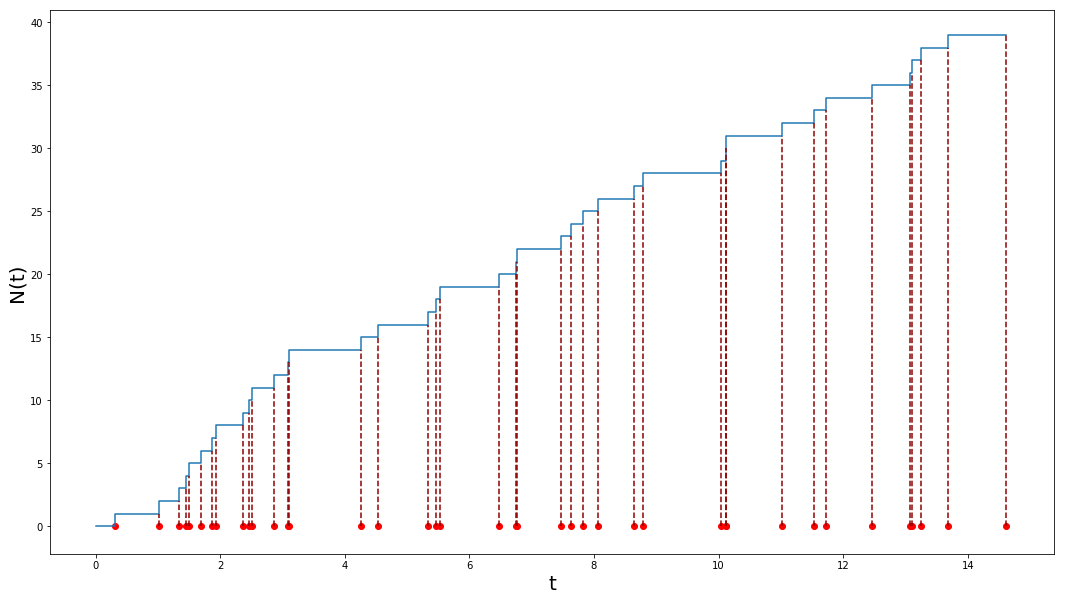

In [8]:
plot_PP(Simulate_HPP(3, 15))

We simulate an IPP with bounder intensity function $\lambda(t) = t/4 $ on $[0,15]$. 

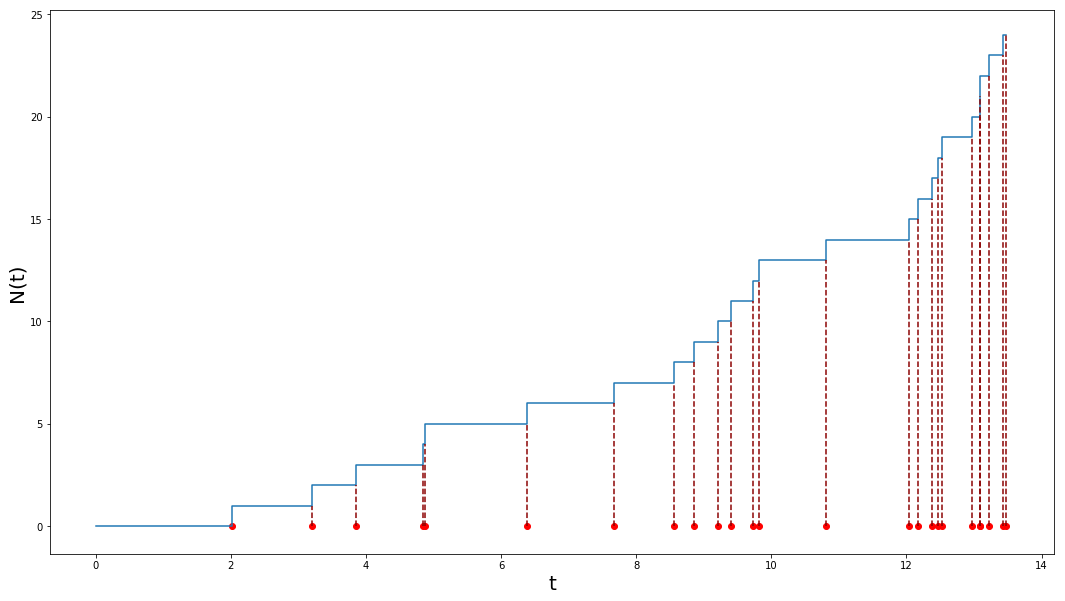

In [9]:
def lamb0(t):
    return t/4
plot_PP(Simulate_IPP(lamb0, 15))

In [10]:
mu = 1.2
alpha = 0.6
beta = 0.8
T = 15

@interact(alpha=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.8, continuous_update=False),
          beta=widgets.FloatSlider(min=0, max=3, step=0.1, value=2.0, continuous_update=False))
def test_param(alpha, beta):
    if alpha < beta:
        plot_Hawkes(mu, alpha, beta, T)
    else:
        print("Alpha must be lower than beta !")

interactive(children=(FloatSlider(value=0.8, continuous_update=False, description='alpha', max=3.0), FloatSlid…

With $\alpha = 0$, we found a Homogenous Poisson Process.

When $\alpha$ increases, the more the processes jump, the more it is self-excited. 

The more $\beta$ increases, the faster is the decrease of $\lambda$. 

## Cramer-Lundberg model with Hawkes Processes

In [18]:
@njit
def X_Hawkes(mu, sigma, alpha, beta, T):
    '''Computation of claims utile time T '''
    N = len(Simulate_Hawkes(mu, alpha, beta, T))
    X = np.exp(npr.normal(mu, sigma, N)) #logNormale
    return X

@njit(parallel=True)
def Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta):
    """Computation of the ratio of the expection of S_T from Hawkes processes estimated by Monte-Carlo 
    and the expection of S_T from HPP with parameter mu"""
    range_beta = np.linspace(alpha, 3, nb_beta)
    range_alpha = np.linspace(0, beta, nb_alpha)
    S_beta = np.zeros(nb_beta)
    S_alpha = np.zeros(nb_alpha)
    for i in prange(N):
        S_beta += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for beta in range_beta])
        S_alpha += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha])
    S_beta = S_beta / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    S_alpha = S_alpha / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    
    return range_alpha, S_alpha, range_beta, S_beta
    
def plot_rapports(range_alpha, S_alpha, range_beta, S_beta, alphas, betas):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
    
    for S, r_beta, alpha in zip(S_beta, range_beta, alphas):
        ax[0].plot(r_beta, S, label=r"$\alpha = $" + str(alpha))
    ax[0].set_title("Ratio with " + r"$\alpha$" + " fixed", fontsize=25)
    ax[0].set_xlabel(r"$\beta$", fontsize=25)
    ax[0].set_ylabel(r"$E[S_T^H] / E[S_T^N]$", fontsize=25)
    ax[0].legend(prop={'size': 25})
    
    for S, r_alpha, beta in zip(S_alpha, range_alpha, betas):
        ax[1].plot(r_alpha, S, label=r"$\beta = $" + str(beta))
    ax[1].set_title("Ratio with " + r"$\beta$" + " fixed", fontsize=25)
    ax[1].set_xlabel(r"$\alpha$", fontsize=25)
    ax[1].set_ylabel(r"$E[S_T^H] / E[S_T^N]$", fontsize=25)
    
    ax[1].legend(prop={'size': 25})
    plt.show()

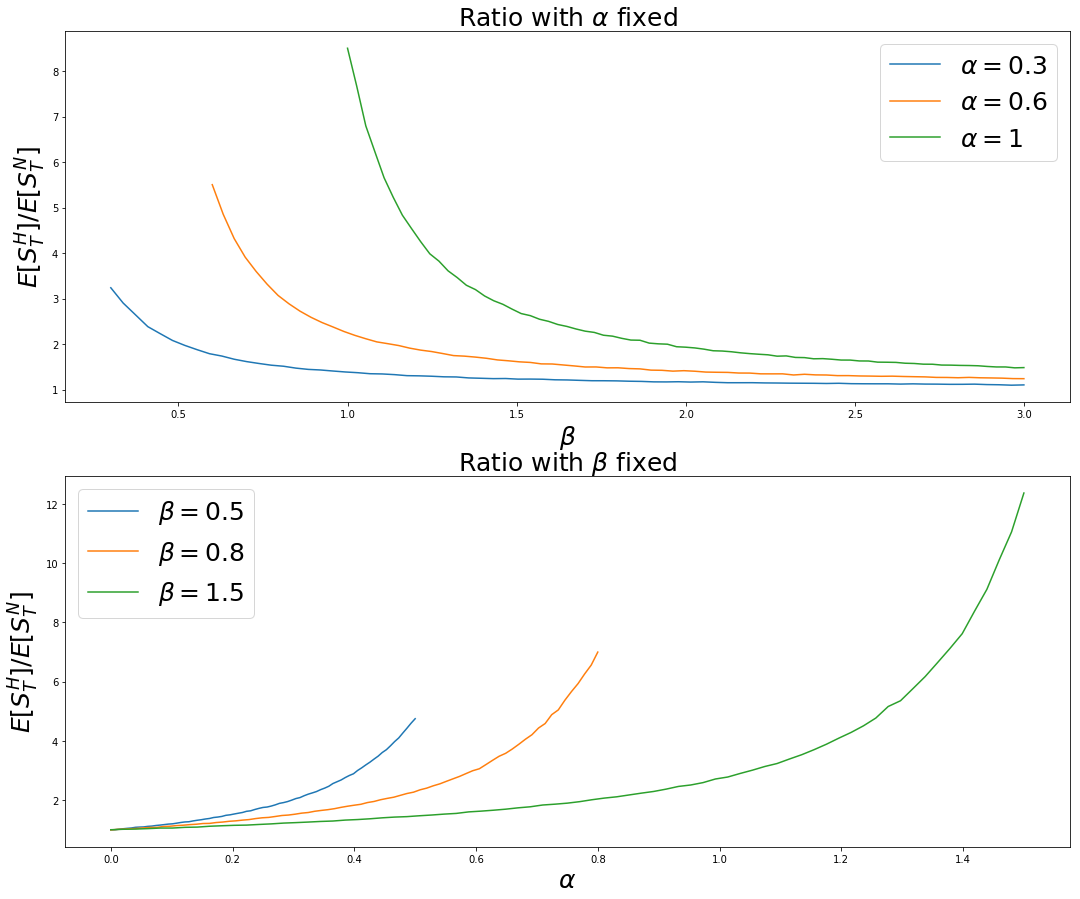

In [12]:
mu = 1.2
sigma = 1
T = 15
alphas = [0.3, 0.6, 1]
betas = [0.5, 0.8, 1.5]
N = 10000
nb_alpha = 75
nb_beta = 75
range_beta = []
range_alpha = []
S_alpha = []
S_beta = []

for alpha, beta in zip(alphas, betas):
    range_alpha_i, S_alpha_i, range_beta_i, S_beta_i = Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta)
    range_alpha.append(range_alpha_i)
    range_beta.append(range_beta_i)
    S_alpha.append(S_alpha_i)
    S_beta.append(S_beta_i)
    
plot_rapports(range_alpha, S_alpha, range_beta, S_beta, alphas, betas)

In order to see the variations of $\alpha$ and $\beta$ at the same time, we create a matrix. 

In [13]:
@njit(parallel=True)
def mat_ratio_exp_val(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta):
    range_alpha = np.linspace(0, alpha_max, nb_alpha)    
    range_beta = np.linspace(alpha_max, beta_max, nb_beta)
    result = np.zeros((nb_alpha, nb_beta))
    
    for i in prange(N):
        for ind, beta in enumerate(range_beta):
            result[:, ind] += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha[::-1]])
    
    result = result / N # Mean on N samples
    result = result / (T * mu * np.exp(mu + sigma ** 2 / 2))  # Expectations ratios
    
    return result, range_alpha, range_beta

def plot_mat_ratio(result, range_alpha, range_beta):
    fig, ax = plt.subplots(figsize=(13, 8))
    sns.heatmap(result, annot=True, cbar=True, xticklabels=np.round(range_beta, 2), yticklabels=np.round(range_alpha[::-1], 2))
    ax.set_xlabel("Values of beta")
    ax.set_ylabel("Values of alpha")
    plt.show()

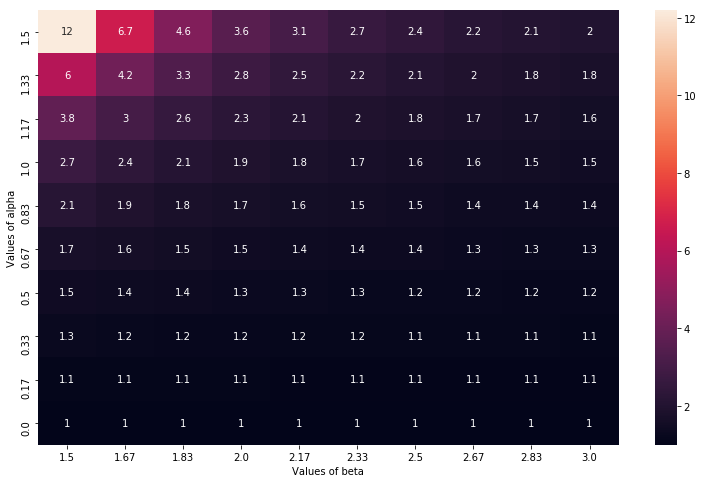

In [14]:
mu = 1.2
sigma = 1
T = 15
N = 10000
nb_alpha = 10
nb_beta = 10
alpha_max = 1.5
beta_max = 3

plot_mat_ratio(*mat_ratio_exp_val(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta))

## Particular Case

In this case, we will take into account the importance of a claim. Beyond a threshold, we consider that the repercussions of a disaster are more important. For example, in health insurance, the more an accident is important, the more important an accident is, the more abundant and expensive the medical needs will be. 

We modelize $\lambda$ as $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) \mathbb{1}_{X_k > S} $ with $X_k$ the value of the claim and $S$ the threshold. 

In [19]:
@njit
def lambda_bar_threshold(mu, alpha, beta, s, tau, X, threshold):
    S = mu
    for ind, t in enumerate(tau[1:]):  # We don't touch the first 0.0
        S += alpha * np.exp(- beta * (s - t)) * (X[ind + 1] >= threshold)
    return S

@njit
def Simulate_Hawkes_threshold(mu, sigma, alpha, beta, T, S):
    tau = [0.0]
    s = 0
    X = [0.0]
    while s < T:
        X += list(np.exp(npr.normal(mu, sigma, 1))) #logNormal law
        lamb_bar = lambda_bar_threshold(mu, alpha, beta, s, tau, X, S)
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar_threshold(mu, alpha, beta, s, tau, X, S):
            tau += [s]
        else:
            del X[-1]
        
        
    if tau[-1] < T:
        return tau[1:], np.array(X[1:])
    else:
        return tau[1:-1], np.array(X[1:-1])

def lamb_Hawkes_threshold(t, tau, mu, alpha, beta, X, S):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) * (X[ind] > S) for ind, Tau in enumerate(tau_inf)])

### Evaluation of the threshold

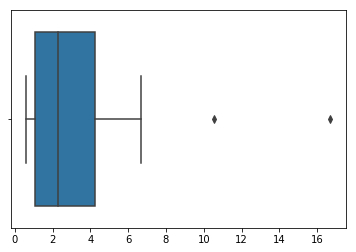

In [16]:
T = 15
mu = 1.2
sigma = 1
alpha = 0.8
beta = 2.0
X = X_Hawkes(mu, sigma, alpha, beta, T)
sns.boxplot(X)
plt.show()

In [17]:
S = np.quantile(X, 0.75)
print("3rd quartile : ", np.quantile(X, 0.75))
print("Maximum of the claims : ", max(X))

3rd quartile :  4.23798338877028
Maximum of the claims :  16.697249569794298


In [20]:
def plot_Hawkes_threshold(mu, sigma, alpha, beta, T, S):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau, X = Simulate_Hawkes_threshold(mu, sigma, alpha, beta, T, S)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes_threshold(t, tau, mu, alpha, beta, X, S) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes_threshold(Tau, tau, mu, alpha, beta, X, S)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t", fontsize=20)
    ax[0].set_ylabel("N(t)", fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)", fontsize=20)
    
    ax[0].set_title("Hawkes Process with threshold S = " + str(S) + ", " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

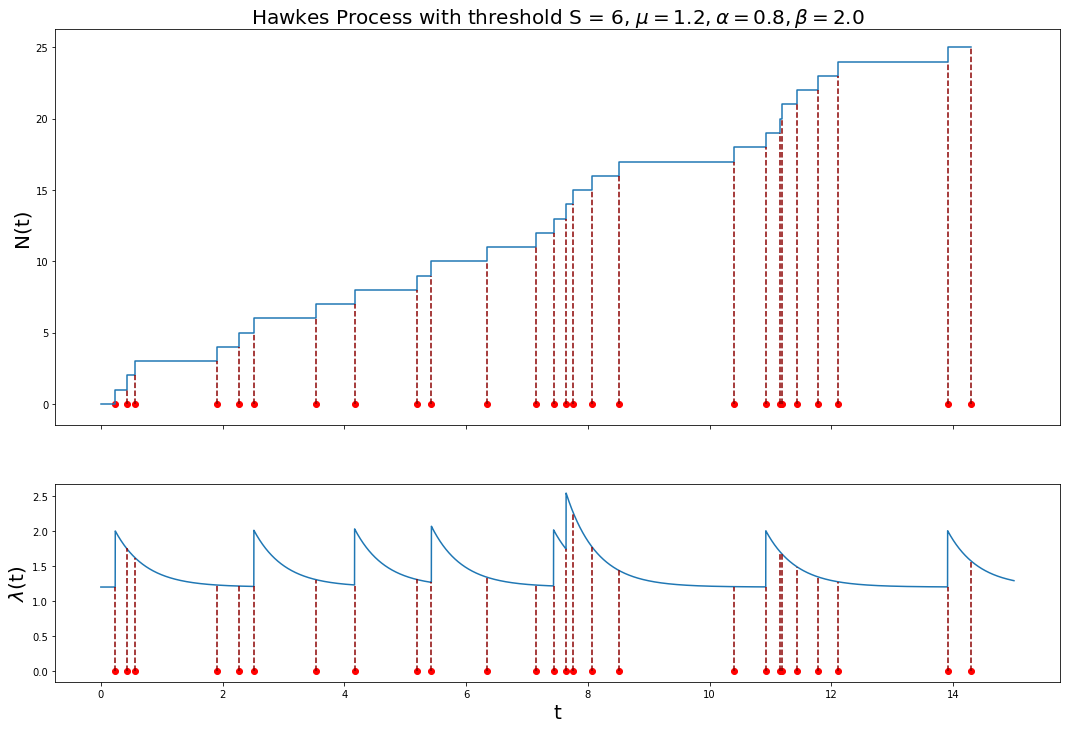

In [19]:
mu = 1.2
sigma = 1
alpha = 0.8
beta = 2.0
S = 6
plot_Hawkes_threshold(mu, sigma, alpha, beta, T, S)

In [21]:
@njit(parallel=True)
def Ratio_ST_Hawkes_threshold(mu, sigma, alpha, beta, T, N, nb_threshold, threshold_max):
    """Computation of the ratio of the expection of S_T from Hawkes processes thresholded and estimated by Monte-Carlo 
    and the expection of S_T from Hawkes estimated by Monte-Carlo"""
    
    range_threshold = np.linspace(0, threshold_max, nb_threshold)    
    S_Hawkes = np.zeros(nb_threshold)
    S_Hawkes_threshold = np.zeros(nb_threshold)
    
    for i in prange(N):
        S_Hawkes += np.array(np.sum(X_Hawkes(mu, sigma, alpha, beta, T)))
        S_Hawkes_threshold += np.array([np.sum(Simulate_Hawkes_threshold(mu, sigma, alpha, beta, T, threshold)[1]) for threshold in range_threshold])
        
    S_threshold = S_Hawkes_threshold / S_Hawkes
    return range_threshold, S_threshold

In [22]:
def plot_ratio_hawkes_threshold(range_threshold, S_threshold):
    fig, ax = plt.subplots(figsize=(18, 15))
    
    ax.plot(range_threshold, S_threshold)
    ax.set_title("Ratio between Hawkes_threshold and Hawkes", fontsize=20)
    ax.set_xlabel("Threshold", fontsize=20)
    ax.set_ylabel(r"$E[S_T^{H\_threshold}]/E[S_T^H]$", fontsize=20)
    plt.show()

In [23]:
mu = 1.2
sigma = 1
alpha = 0.6
beta = 2.0
T = 15
N = 10000
nb_threshold = 70
threshold_max = 20

range_threshold, S_threshold = Ratio_ST_Hawkes_threshold(mu, sigma, alpha, beta, T, N, nb_threshold, threshold_max)

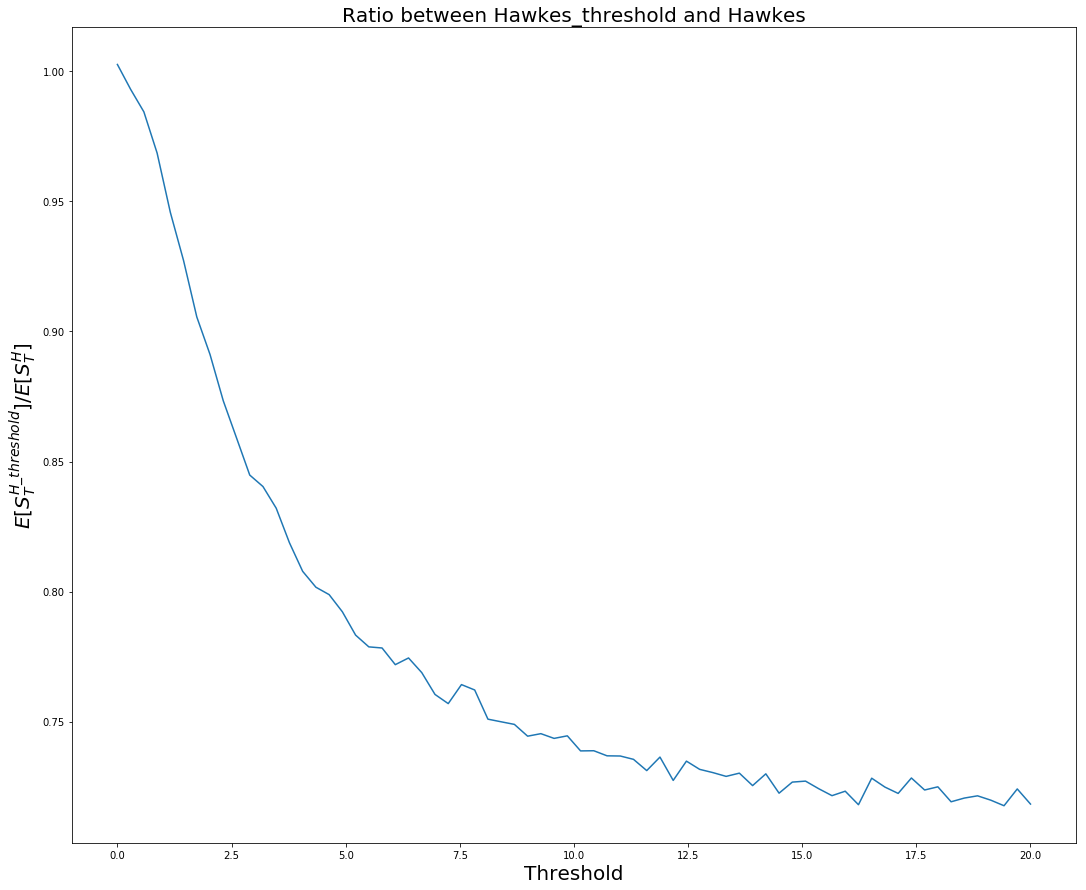

In [24]:
plot_ratio_hawkes_threshold(range_threshold, S_threshold)

In [26]:
import scipy.stats as sps

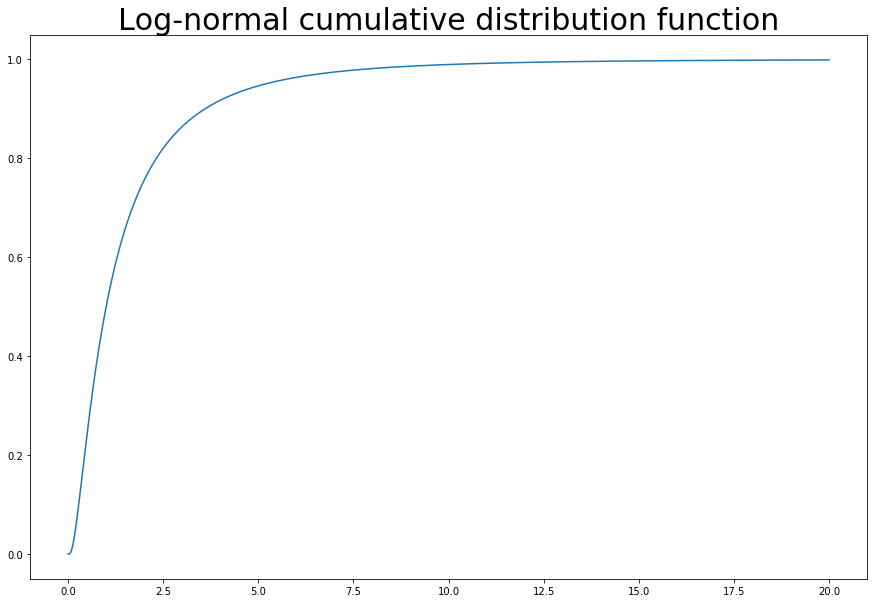

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(np.linspace(0, 20, 10000), sps.lognorm.cdf(np.linspace(0, 20, 10000), 1))
plt.title("Log-normal cumulative distribution function", size=30)
plt.show()